## 员工流失预测项目

### 项目背景
    我们从一些公司获得了员工数据。我们拥有有关 2011 年 1 月 24 日至 2015 年 12 月 13 日加入的所有员工的数据。对于每位员工，我们还知道他们在 2015 年 12 月 13 日仍在公司工作还是已经辞职。除此之外，我们还提供了有关该员工的一般信息，包括其任职期间的平均薪资，部门和工作经验。如上所述，目标是预测员工的留存率并了解其主要驱动因素。
    
### 项目目的
    1）创建一个包含 3 列的表：day，employee_headcount，company_id。
    2）探寻导致员工流失的主要因素及预测员工流失情况

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


data=pd.read_csv("C:/Users/1/data2/practice/employee_retention.csv", parse_dates=['join_date', 'quit_date'])

In [2]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [5]:
table

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
...,...,...,...
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4


In [6]:
#创建一个包含 3 列的表：day，employee_headcount，company_id

# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]     #表示已经离职的这波员工
stay_data = data[data['quit_date'].isnull()]      #表示仍然在职的这波员工

In [7]:
stay_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT
11,904158.0,2,marketing,17,230000.0,2015-05-11,NaT


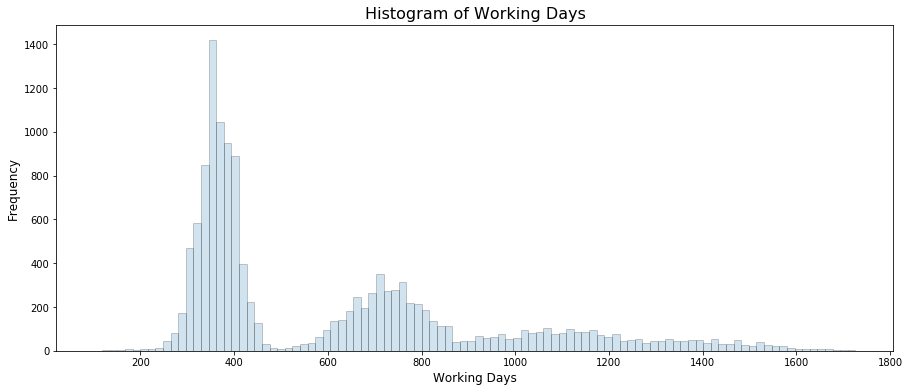

In [8]:
# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

每个员工周年纪念日都有离职高峰（比如工作一年走的；工作两年走的）

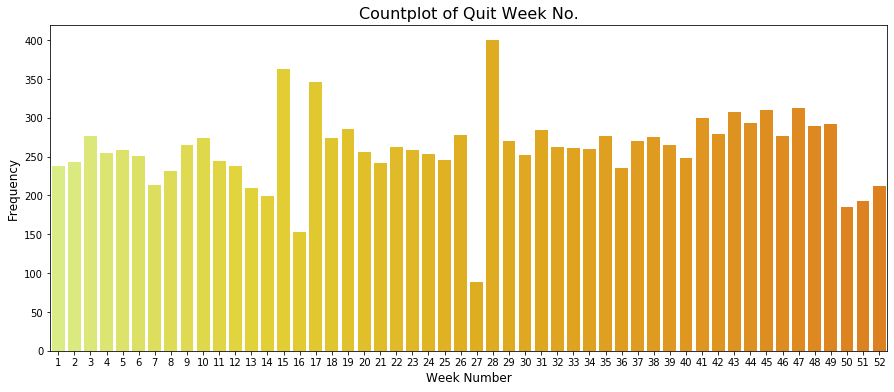

In [9]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax, palette ="Wistia")
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [10]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

In [11]:
# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)
subset.head()

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


现在让我们建立一个模型。在这里，我们可以关心的是：资历，薪水，部门和公司。一个简单的决策树可能绰
绰有余

In [12]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  

#drop user_id, not needed
data111 = subset
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pd.get_dummies(data111)
#model features, test is the label and conversion is not needed here
train_cols = data_dummy.drop(['quit', 'employee_id','join_date','quit_date','company_id'], axis=1)

In [13]:
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['quit'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

![Image of image](https://raw.githubusercontent.com/haki-777/pictures/master/image1.png)

并不奇怪！薪水是最重要的。毕竟，它里面也可能包含有关其他变量的信息。也就是说，资历，部门和公司影
响工资。因此，薪水包含了几乎所有可用的信息。
但是，有趣的是，从终端节点看，树的拆分方式是：如果薪水在 62500 和 224500 之间，则员工有较高的可能
性成为提前退出的人，否则她就没有。这意味着赚很多钱但很少赚钱的人不太可能辞职。

通过按薪资百分比绘制提前退出的比例，这很清楚：

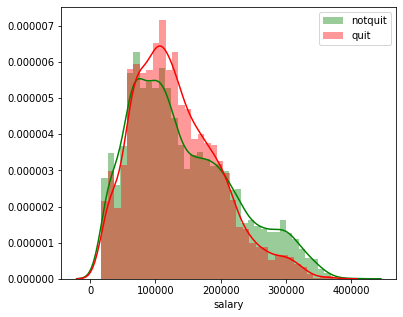

In [15]:
from scipy.stats import norm
fig=plt.figure(figsize=(6,5))
sns.distplot(subset['salary'][subset['quit']==0],color='g',label='notquit')
sns.distplot(subset['salary'][subset['quit']==1],color='r',label='quit')
plt.legend(loc='best')


绿色部分是没有离职员工，可以看出绿色部分主要是在高薪和低薪这两坨，说明高薪的员工或者极低薪员工离职意愿最低，恰好是薪水居中的员工比较爱跳槽。

而且它也在新的一年左右达到顶峰。有意义的是，公司在年初会雇用更多的钱。
现在，让我们看看是否找到早退人员的特征。看看 job_length 的直方图，看来我们可以将早期戒烟者定义为那
些在 1 年左右内戒烟的人。因此，让我们创建两类用户：是否在 13 个月内退出（如果他们至少在 13 个月内未
在当前公司任职，我们将其删除）。

结论
1. 鉴于薪金有多重要，我绝对希望将下岗工作所提供的离职员工的薪水作为变量。否则，诸如：在雇员任职期间获得升职或加薪之类的事情将很有趣。
2. 主要发现是员工在周年纪念日或年初开始辞职。他们经常会在辞职之前停留 1 年，而您经常会在 1 年之后获得提升，因此等待是有意义的。此外，年初是换工作的最佳时机：公司正在招聘更多人，并且他们通常希望一直待到 12 月底才能获得年底奖金。
3. 低薪和高薪的员工离职的可能性较小。可能是因为高薪员工很高兴，而低薪员工却没有那么适合销售，因此他们很难找到新工作。

参考链接：
《a collection of data science take home challenge》

https://github.com/JifuZhao/DS-Take-Home/blob/master/03.%20Employee%20Retention.ipynb